In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import necessary libraries and packages



In [1]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


2024-04-21 14:06:28.648667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 14:06:28.648781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 14:06:28.769632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Lets' create checkpoints folder where we can store model wieights**

In [2]:
cd /kaggle/working

/kaggle/working


In [3]:
ls -lrt

total 8
-rw-r--r-- 1 root root    2 Apr 21 14:05 state.db
drwxr-xr-x 2 root root 4096 Apr 21 14:05 checkpoints/


In [4]:
mkdir checkpoints

mkdir: cannot create directory 'checkpoints': File exists


In [6]:
ls -lrt

total 8
-rw-r--r-- 1 root root    2 Apr  7 15:56 state.db
drwxr-xr-x 2 root root 4096 Apr  7 15:56 checkpoints/


In [7]:
cd checkpoints

/kaggle/working/checkpoints


In [8]:
pwd

'/kaggle/working/checkpoints'

**Set the training directory path to import training datset**

In [5]:
train_data_dir='/kaggle/input/emotion-detection-fer/train/'

# Image data augmentation

**Image data augmentation use to create variations in existing images by applying image augmentation properties like rotation, zoom, filp etc , this will increase train dataset size  and will also help to improve accuracy of model by adding variation in existing dataset.

We are using Keras ImageDataGenerator to augment train dataset.**

In [6]:
train_data_dir='/kaggle/input/emotion-detection-fer/train/'
train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.3,
    zoom_range=0.3,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
     )



In [7]:
train_generator = train_datagen.flow_from_directory(
 train_data_dir,
 color_mode='rgb',
 target_size=(255,255),
 batch_size=4,
 class_mode='categorical',
 subset='training',
 shuffle=True)




Found 28709 images belonging to 7 classes.


# Function to print models layers and set trainable = false for all layers of model. 

In [8]:
def model_layers(model_conv):

  model_conv.trainable = False

  for layer in model_conv.layers:
    print(layer.name,layer.trainable)

# Function to finetune pre-trained mode layers

**In this function we are accpting model (convbase) and no.of layers which we want to fine tune (fine_tune).**

In [9]:
def set_trainable(convbase, fine_tune):

  convbase.trainable = True

  #set_trainable = True
  for layer in convbase.layers[:fine_tune]:
    layer.trainable = False



  return convbase

In [11]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [25]:
import keras
print(keras.__version__)

2.15.0


# Test and validation image data

**Let's set path for validation and test image dataset and import test , validation image data**

In [11]:
test_data_dir='/kaggle/input/emotion-detection-fer/test/'
test_datagen = ImageDataGenerator(
validation_split=0.2)


val_datagen = ImageDataGenerator(
    validation_split=0.2)

test_generator = test_datagen.flow_from_directory(test_data_dir,color_mode='rgb',
                                                       target_size=(255, 255),
                                                       batch_size=1,
                                                       class_mode='categorical',
                                                       subset='training',
                                                       shuffle=True)

validation_generator = val_datagen.flow_from_directory(test_data_dir,color_mode='rgb',
                                                       target_size=(255, 255),
                                                       batch_size=4,
                                                       class_mode='categorical',
                                                       subset='validation',
                                                       shuffle=True)



Found 5746 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


# Create list of output class labels

In [8]:
class_labels=['Angry', 'disgusted', 'fearful', 'Happy','Neutral','Sad','Surprise']

l ={0:'Angry', 1:'disgusted', 2:'fearful', 3:'Happy', 4:'Neutral',5:'Sad', 6:'Surprise'}

# Let's import EfficientNetV2M model

EfficientNetV2M model is CNN model which is pre-trained on imagenet datset.
We will import fully connected layers except output layer by setting inlude_top=Flase, downloading imagenet wieights for efficientNet model and setting input shape of size (255, 255, 3).

In [12]:
conv_base_EffiecientNetv2M =tf.keras.applications.efficientnet_v2.EfficientNetV2M(
    include_top=False,
    weights='imagenet',
    input_shape=(255, 255, 3)
    
)

214201816/214201816 [==============================] - 1s 0us/step


# Print no. of layers of EfficientNetV2M model

In [13]:
print("Number of layers in the Inception base model: ", len(conv_base_EffiecientNetv2M.layers))

Number of layers in the Inception base model:  740


# Fine tuning EfficientNetV2M model

In fine tuning pre-trained model we decides how many layers of EffiecieNetV2M model we can use for traning on emotion detection dataset.
Here, I have tested model by freezing diffenet no. of layers but i got more acuracy when I tried to use all layers to train on Emotion detection datset.

In [14]:
conv_base_EffiecientNetv2M = set_trainable(conv_base_EffiecientNetv2M, 0)

for layer in conv_base_EffiecientNetv2M.layers:
    print(layer.name,layer.trainable)

input_1 True
rescaling True
stem_conv True
stem_bn True
stem_activation True
block1a_project_conv True
block1a_project_bn True
block1a_project_activation True
block1a_add True
block1b_project_conv True
block1b_project_bn True
block1b_project_activation True
block1b_drop True
block1b_add True
block1c_project_conv True
block1c_project_bn True
block1c_project_activation True
block1c_drop True
block1c_add True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_project_conv True
block2b_project_bn True
block2b_drop True
block2b_add True
block2c_expand_conv True
block2c_expand_bn True
block2c_expand_activation True
block2c_project_conv True
block2c_project_bn True
block2c_drop True
block2c_add True
block2d_expand_conv True
block2d_expand_bn True
block2d_expand_activation True
block2d_project_conv True
block2d_project_bn True
bloc

In [15]:
conv_base_EffiecientNetv2M.summary()

Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 255, 255, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 255, 255, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 128, 128, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 128, 128, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                

# Adding fully connected and output layer to EfficientNetV2M model 

1] We are storing the output of last convolutional layer to feed fully connected layer. 
before feeding the output of last convolutional layer to fully connected layer we need to onvert 3d tensor to 1d tensor as fully connected layer accepts input in 1d form. We are using **GlobalAveragePooling2D** to flatten the output of last convolutional layer. 

GlobalAveragePooling2D() function works same as flatten(), only difference is flatten() maintain all the features of convolutional layer and GlobalAveragePooling2D() takes avarage of all the feature maps 
For tensor shape like (8, 8, 1280) it will take average of 8X8 features maps (1280) , which will convert tesnsor into (batch_szie X no_of_feature_maps) i.e 4x1280 in our case.

**GlobalAveragePooling2D** helps to reduce intense tensor shape which can cause overfitting to our model.


2] We are adding dense layers to create fully connected network after flattenning tensor shape using GlobalAveragePooling2D layer.

3] **Dropout layer**: I have used dropout layer to overcome overfitting in a model. Dropout layers unuses no. of neurons for that epoch randomly, this helps to focus on each and every pattern instead of some fixed patterns, this reduce dependancy of neurons from previous layers, introduce different neural architecture by dropping neurons randomly.


4] **Batch normalization**: Batch normalization helps to speed up and stabilize training of any neural network model.
In batch normalization we are trying to reduce the effect of "Internal Covariate Shift" which causes delay in convergenece of model towards global minima. 
Internal Covariate Shift is the change in the distribution of network activations due to the chang in network parameter during training.

In deep neural network activation of neurons depends upon w and b parameter of network which keeps changing throughout the training of model which causes change in distribution. For this we have to keep learnin rate (n) bery slow which causes slow training.

Batch-normalization is works only with mini-batch and its applied before relu i.e non-linear activation function.
It normalizes the activation of neurons by calaculating mean and variance of mini-batch data and apply stardard deviation. It uses Gamma and beta learnable paraetrs which apply scale and shift method to input of activations function.

5] **Activation fucntion**: we are using **elu** activation function for all the fully connected networks hidden layers and softmax activation fucntion for output layer as we have to predict 7 categories of emotions.




In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model


x = conv_base_EffiecientNetv2M.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(3000, activation='elu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(2024, activation='elu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(1050, activation='elu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(1000, activation='elu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(562, activation='elu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(200, activation='elu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(100, activation='elu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model_Efficientnetv2M = Model(inputs=conv_base_EffiecientNetv2M.input, outputs=predictions)

# Model Callback

**ModelCheckpoint :** We need to save weights of model whle training for future use, for this we need to create modelcheckpoint. Here, I am monitoring val_loss , It will overwrite the filepath of saved model by each best model. verbose=1 dispalys message when callback takes an action.

**earlystop :** Early stopping is uesed to stop training of model, when model tries to overfit or model loss is not decreasing at all. min_delta is  the amount of change in loss which is qualify as an model improvement. **patience** is no. of epochs without ay improvement in model accuracy after thattraining will stopped. 

**ReduceLROnPlateau :** Reduce learning rate when monitored quantity is not improving. **Patience** is no.of epochs with no improvement after that learning rate will get decrease. **factor** by which learning rate will get reduced. **min_delta** Threshold for measuring the new optimum, to only focus on significant changes.


In [ ]:
checkpoint_M = ModelCheckpoint('/kaggle/working/checkpoints/Emotion_Detection_Model_Efficient_v2M.keras',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)


callbacks_v2M = [earlystop,checkpoint_M,reduce_lr]

**Complie model before trainning**

In [ ]:
model_Efficientnetv2M.compile(optimizer=Adam(1e-5) , loss='categorical_crossentropy', metrics=['accuracy'])


**Training Model**

In [ ]:
history_efficientv2M = model_Efficientnetv2M.fit(train_generator,epochs=50, validation_data=validation_generator, callbacks=callbacks_v2M)

In [ ]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history_efficientv2M, 'accuracy')

In [9]:
from keras.models import load_model

# Loading saved model for testing purpose

In [10]:
classifier = load_model('/kaggle/input/emotion_detection_model/keras/emotion_detection/1/Emotion_Detection_Model_v2M.keras', compile=True)

# Prediction on test data

In [12]:
y_pred = classifier.predict(test_generator)

5746/5746 [==============================] - 146s 24ms/step


In [14]:
output = classifier.evaluate(test_generator)

5746/5746 [==============================] - 162s 28ms/step - loss: 1.0166 - accuracy: 0.6272


# Creating list of test output 

In [17]:
label=[]
for i in range(1, 5747):
    img, l = test_generator.next()
    label.append(l)
    

l.shape

(1, 7)

# Converting list to array

In [18]:
import numpy as np

label = np.array(label)

In [19]:
label.shape

(5746, 1, 7)

# Reshaping actual test output array

In [20]:
new_label = label.reshape((label.shape[0]*label.shape[1]), label.shape[2])

In [21]:
new_label.shape

(5746, 7)

In [15]:
y_pred.shape

(5746, 7)

# Printing confusion matrix of actaul and predicted output

In [22]:
from sklearn.metrics import classification_report, confusion_matrix


predicted_labels = np.argmax(y_pred, axis=1)
test_integer_labels = np.argmax(new_label, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_integer_labels, predicted_labels)

print(cm)

[[100   0  85 199 149 158  76]
 [ 10   0  13  13  20  23  10]
 [121   2  91 227 140 141  98]
 [185   1 162 369 250 301 152]
 [119   1  92 257 184 231 103]
 [120   1 117 262 182 202 114]
 [ 87   0  80 171 124 126  77]]


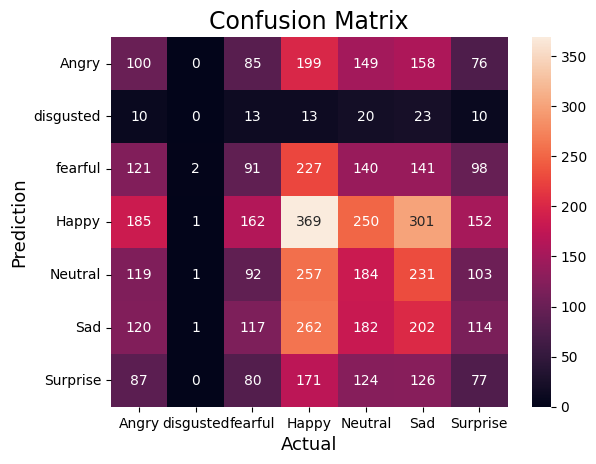

In [23]:
import seaborn as sns


sns.heatmap(cm,
annot=True,
fmt='g',
xticklabels=['Angry', 'disgusted', 'fearful', 'Happy','Neutral','Sad','Surprise'],
yticklabels=['Angry', 'disgusted', 'fearful', 'Happy','Neutral','Sad','Surprise'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()


In [24]:
#class_labels = list(test_set.class_labels.keys())   
report = classification_report(test_integer_labels, predicted_labels, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       Angry       0.13      0.13      0.13       767
   disgusted       0.00      0.00      0.00        89
     fearful       0.14      0.11      0.12       820
       Happy       0.25      0.26      0.25      1420
     Neutral       0.18      0.19      0.18       987
         Sad       0.17      0.20      0.19       998
    Surprise       0.12      0.12      0.12       665

    accuracy                           0.18      5746
   macro avg       0.14      0.14      0.14      5746
weighted avg       0.17      0.18      0.17      5746

